#**Implementing Feature Selection**
Feature selection is the process of reducing the number of input variables when developing a predictive model. The goals of applying feature selection to our model is <i>removing irrelevant feature (features that do not really play a role in determining the data class) and reducing the time complexity of our model.</i> **But you have to know that**:
- Doing feature selection does not always improve the model accuracy (but the goal is to improve model accuracy)
- Feature selection always speeds up the modeling process, because it's reducting the dimension of the dataset.

Following are the selection features that will be discussed in this module:
<ol>
  <li>Recursive Feature Elimination (RFE)</li>
  <li>Feature Importance</li>
  <li>Boruta</li>
  <li>Plot Importance - XGBoost</li>
</ol>   

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')

###**Read the dataframe**

In [32]:
#read the data from url and set the column name
col = ['preg', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedi', 'age', 'class']
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/pima-indians-diabetes.csv", names=col)
df.head()

,preg,glucose,bp,skin,insulin,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [33]:
#check missing value and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   preg     768 non-null    int64  
 1   glucose  768 non-null    int64  
 2   bp       768 non-null    int64  
 3   skin     768 non-null    int64  
 4   insulin  768 non-null    int64  
 5   bmi      768 non-null    float64
 6   pedi     768 non-null    float64
 7   age      768 non-null    int64  
 8   class    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


###**Correlation Matrix with Heatmap**

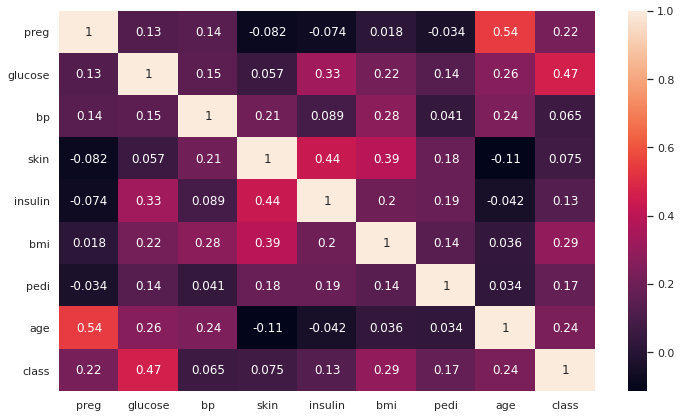

In [34]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True)
plt.show()

We can see from an intial analysis of the heatmap that glucose, bmi, age, preg, pedi and insulin are the top 6 features that have relatively high correlation(positive) with the target. It means that as they increase, the chance get diabetes of the patient also increase. Age, and preg are highly correlated with each other.
<br><br>
Now, you might say why note remove irrelevant features by intuition or just looking at the heatmap? In general, <b>it isn't advisable to be influenced by one's bias or intuition</b>.

###**Split the data**
<b>Note:</b> we shold split the data before preprocessing step to prevent data leakage (when your preprocessing know your test characteristic).

In [35]:
input = df.drop('class', axis=1)
output = df['class']

x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.33, random_state=1)

###**Basic Steps**
- Train a baseline classifier (any classifier like logistic regression or random forest trained with all the features in dataset)
- Identify the most impratant features using a feature selection technique.
- Create a new 'limited features' dataset containing only those features.
- Train a second classifier on this dataset.
- Compare the accuracy of the 'full featured' (baseline) to the accuracy of the 'limited featured' (new) classifier.

###**Feature Selection 1 - Recursive Feature Elimination (RFE)**

In [36]:
lr = LogisticRegression(random_state=1)
lr_baseline_model = lr.fit(x_train, y_train)

print("Baseline Accuracy Score: ", accuracy_score(lr_baseline_model.predict(x_test), y_test))
print("Baseline F1 Score: ", f1_score(lr_baseline_model.predict(x_test), y_test))

Baseline Accuracy Score:  0.7795275590551181
Baseline F1 Score:  0.6455696202531646


<b>Applying RFE</b>

In [37]:
# estomator is the model that we want to use
# step : removes one of the feature at a time and then builds a model on the remaining features. You can also set to 2,3, etc (take top-n features)
rfe = RFE(estimator=lr, step=1)
rfe_fit = rfe.fit(x_train, y_train)

print('Num Features\t\t: %d' %rfe_fit.n_features_)
print('Selected Features\t: %s' %rfe_fit.support_)
print('Feature Ranking\t\t: %s' %rfe_fit.ranking_)

Num Features		: 4
Selected Features	: [ True  True False False False  True  True False]
Feature Ranking		: [1 1 3 4 5 1 1 2]


In [38]:
selected_feature = pd.DataFrame({'Features':list(x_train.columns),
                                 'Ranking':rfe.ranking_})
selected_feature.sort_values(by='Ranking')

,Features,Ranking
0,preg,1
1,glucose,1
5,bmi,1
6,pedi,1
7,age,2
2,bp,3
3,skin,4
4,insulin,5


From that data we can say that "RFE gives preg, glucose, bmi and pedi" at the first rank

<b>Create a new subset of the data with only the selected features</b>

In [39]:
#transform
x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)

#fit the model with our selected data
lr_rfe_model = lr.fit(x_train_rfe, y_train)

#model performance with feature selection
print("RFE Accuracy Score: ", accuracy_score(lr_rfe_model.predict(x_test_rfe), y_test))
print("RFE F1 Score: ", f1_score(lr_rfe_model.predict(x_test_rfe), y_test))

RFE Accuracy Score:  0.7795275590551181
RFE F1 Score:  0.641025641025641


**Conclusion**<br>
- The model accuracy for complete dataset and dataset with feature selection is the same : 77.953%. But complete dataset has slightly better F1-score (64.6%) than dataset with feature selection (64.1%).
- Althought feature selection doesn't make the better accuracy, but model with feature selection data faster than without feature selection. 
- Because the difference in accuracy is very small, so I recommend using feature selection data to reduce the time complexity.

###**Feature Selection 2 - Feature Imprtance Using Random Forest**

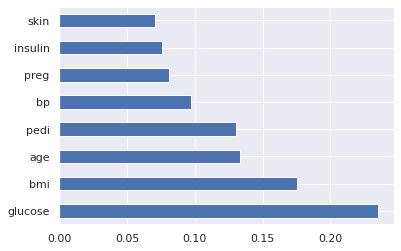

In [40]:
rf = RandomForestClassifier(n_estimators=1000, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

#get the feature importance from model
feature_imp = pd.Series(rf.feature_importances_, index = x_train.columns)
feature_imp.nlargest(10).plot(kind='barh')
plt.show()

sum of all feature importances above is 100%, and we can see that the 4 higher feature importance is glucose, bmi, age and pdi (like FRE result). And the sum of imprtance feature is about (0.24+0.17+0.13+0.125) = 66,5%

<b>Identify and select most important features</b>

In [41]:
#it will select the features based on the importance score
rf_select_feature = SelectFromModel(rf)
# rf_select_feature = SelectFromModel(rf, threshold=0.13), but if you don't set the threshold, it's oky

#train the selected feature
rf_sf = rf_select_feature.fit(x_train, y_train)

<b>Create a new subset of the data with only the selected features</b>

In [42]:
x_imp_train = rf_sf.transform(x_train)
x_imp_test = rf_sf.transform(x_test)

In [43]:
x_imp_train[0] #we can see that the model just use this feature (4 from 8)

array([108.   ,  35.5  ,   0.415,  24.   ])

<b>Train a new RF Classifier model using selected important features</b>

In [44]:
rf_imp_model = RandomForestClassifier(n_estimators=1000, random_state=1, n_jobs=-1)
rf_imp_model = rf_imp_model.fit(x_imp_train, y_train)

<b>Comparasion of the model performance</b>

In [48]:
#model performance with feature selection
print("RF Baseline Accuracy Score\t: ", accuracy_score(rf.predict(x_test), y_test))
print("RF Baseline F1 Score\t\t: ", f1_score(rf.predict(x_test), y_test))
print()
print("RF Baseline Accuracy Score\t: ", accuracy_score(rf_imp_model.predict(x_imp_test), y_test))
print("RF Baseline F1 Score\t\t: ", f1_score(rf_imp_model.predict(x_imp_test), y_test))

RF Baseline Accuracy Score	:  0.7834645669291339
RF Baseline F1 Score		:  0.6583850931677019

RF Baseline Accuracy Score	:  0.7755905511811023
RF Baseline F1 Score		:  0.6586826347305389


**Conclussion**
- Althought we drop some features (from 8 to 4), but the accuracy from the model is not really different while the F1 score is still the same. It means that 4 other features are not very influential in determining the data class. So we can drop the feature (use feature selection).

###**Feature Selection 3 - Boruta**
Boruta tries to capture all the important and interesting features you might have in your dataset with respect to the target variable. Unlike other techniques that select small set of features to minimize the error. By default, bouruta uses random forest although it works with other algorithms like LightGBM, XGBoost etc.

In [49]:
#install library
!pip install Boruta

In [50]:
#import library
from boruta import BorutaPy

**Build the baseline model**

In [51]:
model = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=1, max_depth=7)
model.fit(x_train, y_train)

#predict the baseline model
y_pred = model.predict(x_test)
base_acc = accuracy_score(y_pred, y_test)
base_f1 = f1_score(y_pred, y_test)

**Applying Boruta**

In [52]:
boruta_selector = BorutaPy(model, n_estimators='auto', random_state=1)
boruta_selector.fit(np.array(x_train), np.array(y_train))

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=7, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=45, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F9AA9576258,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto

In [53]:
# check selected features
print("Selected Features: ", boruta_selector.support_)
 
# check ranking of features
print("Ranking: ",boruta_selector.ranking_)

print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [False  True False False False  True  True  True]
Ranking:  [3 1 3 5 2 1 1 1]
No. of significant features:  4


In [54]:
boruta_features = pd.DataFrame({'Feature':list(x_train.columns),
                                'Ranking':boruta_selector.ranking_})
boruta_features.sort_values(by='Ranking')

,Feature,Ranking
1,glucose,1
5,bmi,1
6,pedi,1
7,age,1
4,insulin,2
0,preg,3
2,bp,3
3,skin,5


By using boruta model selection, we got 4 feature in the first rank i.e. glucose, bmi, pedi and age.

**Subset of the selected features**

In [55]:
x_train_b, x_test_b = boruta_selector.transform(np.array(x_train)), boruta_selector.transform(np.array(x_test))

In [56]:
x_train_b[0] #we select feature at the first rank (4 features)

array([108.   ,  35.5  ,   0.415,  24.   ])

In [57]:
#build the model
model2 = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=1, max_depth=7)
model2.fit(x_train_b, y_train)

#predict the model
y_pred = model2.predict(x_test_b)
acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

In [58]:
print("Baseline model accuracy: {0}% f1_score: {1}".format(round(base_acc*100,3), round(base_f1*100,3)))
print("New_fetr model accuracy: {0}% f1_score: {1}".format(round(acc*100,3), round(f1*100,3)))

Baseline model accuracy: 77.559% f1_score: 64.151
New_fetr model accuracy: 78.346% f1_score: 67.066


**Conclussion**
- Both accuracy and f1 score increased slightly when using boruta. The number of features droped from 8 to 4.

##**Plot Importance XGBoost**

Feature Importances :  [0.09570684 0.27991962 0.08152946 0.06598003 0.08882333 0.16970392
 0.09298628 0.12535053]


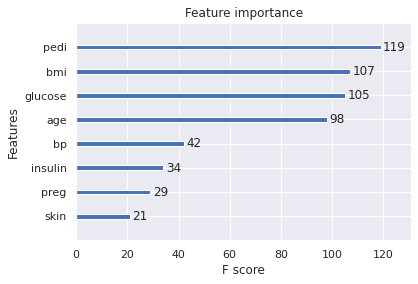

In [59]:
#import the library
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit the data
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(x_train, y_train)

#baseline xgboost
y_pred = xgb_model.predict(x_test)

#baseline model evaluation
xgb_acc_base = accuracy_score(y_test, y_pred)
xgb_f1score_base = f1_score(y_test ,y_pred)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

From XGBoost, we can see that the top 4 features are pedi, bmi, glucose and age

**Select the feature**

In [62]:
selection = SelectFromModel(xgb_model)
selection.fit(x_train, y_train)

# Transform the train and test features
select_x_train = selection.transform(x_train)
select_x_test = selection.transform(x_test) 

# train model
selection_model = XGBClassifier()
selection_model.fit(select_x_train, y_train)

# Model evaluation
predictions = selection_model.predict(select_x_test)
xgb_acc = accuracy_score(y_test, predictions)
xgb_f1score = f1_score(y_test , predictions)

In [63]:
print("Baseline model accuracy: {0}% f1_score: {1}".format(round(xgb_acc_base*100,3), round(xgb_f1score_base*100,3)))
print("New_fetr model accuracy: {0}% f1_score: {1}".format(round(xgb_acc*100,3), round(xgb_f1score*100,3)))

Baseline model accuracy: 78.346% f1_score: 66.258
New_fetr model accuracy: 79.528% f1_score: 69.048


**Conclusion**<br>
XGB with feature selection provides better accuracy than without feature selection.